<a href="https://colab.research.google.com/github/na-learning/Stock-Prediction/blob/main/Stock_prediction_random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [148]:
!pip install yfinance
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz
import os
os.chdir('ta-lib') # Can't use !cd in co-lab
!./configure --prefix=/usr
!make
!make install
os.chdir('../')
!pip install TA-Lib

--2024-07-18 23:16:14--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-07-18 23:16:15--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1 [following]
--2024-07-18 23:16:15--  http://nchc.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz?viasf=1
Resolving nchc.

In [149]:
import yfinance as yf
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import talib as ta
import numpy as np
import pandas as pd

df = yf.Ticker('TSLA').history(period="max")
df = df.drop(columns=['Dividends','Stock Splits'])
df

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29 00:00:00-04:00,1.266667,1.666667,1.169333,1.592667,281494500
2010-06-30 00:00:00-04:00,1.719333,2.028000,1.553333,1.588667,257806500
2010-07-01 00:00:00-04:00,1.666667,1.728000,1.351333,1.464000,123282000
2010-07-02 00:00:00-04:00,1.533333,1.540000,1.247333,1.280000,77097000
2010-07-06 00:00:00-04:00,1.333333,1.333333,1.055333,1.074000,103003500
...,...,...,...,...,...
2024-07-12 00:00:00-04:00,235.800003,251.839996,233.089996,248.229996,155694400
2024-07-15 00:00:00-04:00,255.970001,265.600006,251.729996,252.639999,146912900
2024-07-16 00:00:00-04:00,255.309998,258.619995,245.800003,256.559998,126332500


In [150]:
df['S_10'] = df['Close'].rolling(window=10).mean()
df['Corr'] = df['Close'].rolling(window=10).corr(df['S_10'])
df['RSI'] = ta.RSI(np.array(df['Close']), timeperiod =10)
df['High-Low-Percentage'] = (df['High'].shift(1) - df['Low'].shift(1))/df['Low'].shift(1)
df['Open-Close-Percentage'] = (df['Open'].shift(1) - df['Close'].shift(1))/df['Open'].shift(1)
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df.Date)
df.drop_duplicates(subset ="Date", keep = 'first', inplace = True)
df["Date"] = df["Date"].dt.date

df = df.dropna()
X = df[['Open', 'High', 'Low', 'Volume', 'S_10', 'Corr', 'RSI', 'High-Low-Percentage', 'Open-Close-Percentage']]
y = df['Close']
X

,Open,High,Low,Volume,S_10,Corr,RSI,High-Low-Percentage,Open-Close-Percentage
18,1.433333,1.433333,1.353333,13833000,1.361200,0.186448,43.771926,0.023741,-0.004719
19,1.394000,1.412000,1.350667,9295500,1.377267,0.215493,41.732432,0.059113,0.025581
20,1.370000,1.393333,1.367333,7008000,1.383133,0.113102,42.986814,0.045409,0.017217
21,1.384667,1.392000,1.333333,9240000,1.386200,-0.230016,40.859614,0.019015,-0.008272
22,1.346667,1.362667,1.303333,6403500,1.381533,-0.436291,38.512985,0.044000,0.020221
...,...,...,...,...,...,...,...,...,...
3532,235.800003,251.839996,233.089996,155694400,240.470000,0.722786,68.390475,0.130816,0.084580
3533,255.970001,265.600006,251.729996,146912900,245.945999,0.614622,70.316193,0.080441,-0.052714
3534,255.309998,258.619995,245.800003,126332500,250.615999,0.454251,72.000896,0.055099,0.013009
3535,252.729996,258.470001,246.179993,115584800,252.339999,0.022269,63.736714,0.052156,-0.004896


In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle = False, random_state=3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2991, 9)
(2991,)
(528, 9)
(528,)


In [152]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Create a Random Forest Regressor
rfr = RandomForestRegressor()

# Define the hyperparameters to tune.
param_grid = {'n_estimators': [5, 10, 15, 20], 'max_depth': [2, 4, 8, 15], 'min_samples_split': [2, 4, 8]}

# Create a GridSearchCV object
grid_rf_class = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    cv=5,
    refit=True, return_train_score=True)
print(grid_rf_class)

grid_rf_class.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 15],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_absolute_error')


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 8, 15],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [153]:
print("Best Index: ", grid_rf_class.best_index_)

print("Best Estimator: ", grid_rf_class.best_estimator_)

Best Index:  38
Best Estimator:  RandomForestRegressor(max_depth=15, n_estimators=15)


In [160]:
rfr = RandomForestRegressor(max_depth=15, n_estimators=5, random_state=42)

# Fit the best classifier on the training data.
rfr.fit(X_train, y_train)
predicted = rfr.predict(X_test)

In [161]:
print("Score: ", rfr.score(X_test, y_test))

Score:  0.964635386840904


In [162]:
print(mean_absolute_error(y_test, predicted))

6.20177813410243


In [163]:
dfr=pd.DataFrame({'Actual_Price': y_test, 'Predicted_Price': predicted})
dfr.head(10)

,Actual_Price,Predicted_Price
3009,232.229996,235.636667
3010,215.736664,220.714665
3011,220.889999,220.923338
3012,233.000000,232.289999
3013,213.100006,217.541331
3014,216.759995,215.340001
3015,237.036667,230.275333
3016,236.086670,242.140668
3017,235.070007,235.878668
3018,245.706665,241.162000


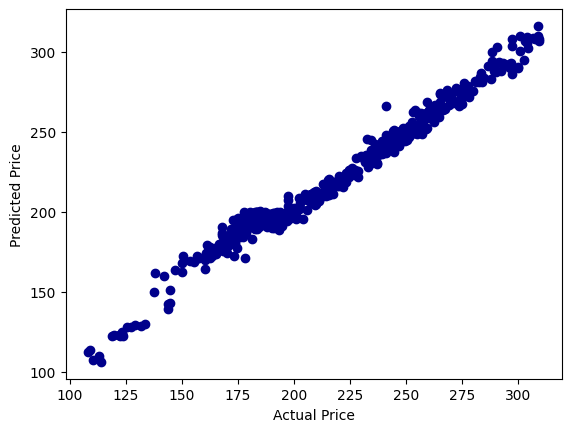

In [164]:
import matplotlib.pyplot as plt

plt.scatter(dfr.Actual_Price, dfr.Predicted_Price, color='Darkblue')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.show()

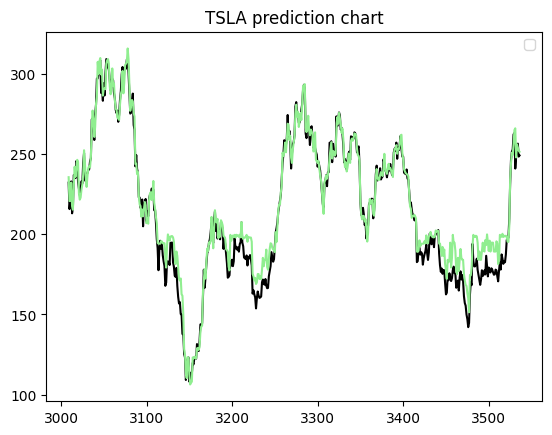

In [165]:
plt.plot(dfr.Actual_Price, color='black')
plt.plot(dfr.Predicted_Price, color='lightgreen')
plt.title("TSLA prediction chart")
plt.legend()